# Hand written digits recognition with Convolutional Neural Network (Tensorflow)

In this notebook we are going to build a Convolutional Neural Network model to recognize hand written digits using Tensorflow.

## Importing packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import tensorflow as tf
from tensorflow.python.framework import ops
%matplotlib inline

## Loading data

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('data/', one_hot=True)

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz


The desired shape for our input layer is (m, 28, 28, 1).

In [3]:
X_train = mnist.train.images.reshape(-1,28,28,1)
Y_train = mnist.train.labels
X_test = mnist.test.images.reshape(-1,28,28,1)
Y_test = mnist.test.labels
print('X_train shape: '+str(X_train.shape))
print('Y_train shape: '+str(Y_train.shape))
print('X_test shape: '+str(X_test.shape))
print('Y_test shape: '+str(Y_test.shape))

X_train shape: (55000, 28, 28, 1)
Y_train shape: (55000, 10)
X_test shape: (10000, 28, 28, 1)
Y_test shape: (10000, 10)


## Building the model

We'll build a model to classify the images in the MNIST dataset using the following CNN architecture:

1. Convolutional Layer #1: Applies 32 5x5 filters (extracting 5x5-pixel subregions) with "same" padding and applying ReLU activation function
2. Pooling Layer #1: Performs max pooling with a 2x2 filter and stride of 2 (which specifies that pooled regions do not overlap)
3. Convolutional Layer #2: Applies 64 5x5 filters with "same" padding and applying  ReLU activation function
4. Pooling Layer #2: Again, performs max pooling with a 2x2 filter and stride of 2
5. Dense Layer #1: 1,024 neurons, with dropout regularization rate of 0.4 (probability of 0.4 that any given element will be dropped during training)
6. Dense Layer #2 (Logits Layer): 10 neurons, one for each digit target class (0–9).


### Creating placeholders

In [4]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_H0 -- scalar, height of an input image (28)
    n_W0 -- scalar, width of an input image (28)
    n_C0 -- scalar, number of channels of the input (1)
    n_y -- scalar, number of classes (10)
        
    Returns:
    X -- placeholder for the data input, of shape [None, n_H0, n_W0, n_C0] and dtype "float"
    Y -- placeholder for the input labels, of shape [None, n_y] and dtype "float"
    """

    X = tf.placeholder(tf.float32,[None, n_H0, n_W0, n_C0])
    Y = tf.placeholder(tf.float32,[None, n_y])
    
    return X, Y

### Initializing parameters

We'll only initialize the weights for the conv2d functions. Tensorflow takes care of the bias and it initializes the layers for the fully connected parts (dense layers) automatically.

In [5]:
def initialize_parameters():
    """
    Initializes weight parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [5, 5, 1, 32]
                        W2 : [5, 5,32 , 64]
    Returns:
    parameters -- a dictionary of tensors containing W1, W2
    """
    W1 = tf.get_variable('W1', [5, 5, 1, 32], initializer=tf.contrib.layers.xavier_initializer())
    W2 = tf.get_variable('W2', [5, 5,32 , 64], initializer=tf.contrib.layers.xavier_initializer())
    
    parameters = {'W1':W1, 'W2':W2}
    
    return parameters
    

### Forward propagation

In [6]:
def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED -> FULLYCONNECTED
    
    Arguments:
    X -- input dataset placeholder
    parameters -- python dictionary containing your parameters "W1", "W2"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    #conv2d
    Z1 = tf.nn.conv2d(X, W1, strides=[1,1,1,1], padding='SAME')
    #relu
    A1 = tf.nn.relu(Z1)
    #max pool
    P1 = tf.nn.max_pool(A1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    #conv2d
    Z2 = tf.nn.conv2d(P1, W2, strides=[1,1,1,1], padding='SAME')
    #relu
    A2 = tf.nn.relu(Z2)
    #max pool
    P2 = tf.nn.max_pool(A2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    #Flatten
    P2 = tf.contrib.layers.flatten(P2)
    #Fully connected layer
    A3 = tf.contrib.layers.fully_connected(P2, num_outputs=1024, activation_fn=tf.nn.relu)
    #Dropout
    dropout = tf.layers.dropout(inputs=A3, rate=0.4)
    # Fully connected without non-linear activation function
    Z4 = tf.contrib.layers.fully_connected(P2, num_outputs=10, activation_fn=None)
    
    return Z4
    

### Computing the cost

In [7]:
def compute_cost(Z4, Y):
    """
    Computes the cost
    
    Arguments:
    Z4 -- output of forward propagation (output of the last LINEAR unit)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Z4, labels=Y))
    
    return cost

### The model

In [16]:
def model (X_train, Y_train, X_test, Y_test, learning_rate=0.001, num_epochs=4, minibatch_size=32, print_cost=True):
    """
    Implements a three-layer ConvNet in Tensorflow:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED -> FULLYCONNECTED
    
    Arguments:
    X_train -- images of the training set
    Y_train -- corresponding labels of the training set
    X_test -- images of the test set
    Y_test -- corresponding labels of the test set
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    train_accuracy -- real number, accuracy on the train set (X_train)
    test_accuracy -- real number, testing accuracy on the test set (X_test)
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    ops.reset_default_graph()
    (m,n_H0,n_W0,n_C0) = X_train.shape
    n_y = Y_train.shape[1]
    num_minibatches = int(m/minibatch_size)
    costs = []
    
    X,Y = create_placeholders(n_H0,n_W0,n_C0,n_y)
    parameters = initialize_parameters()
    
    Z4 = forward_propagation(X, parameters)
    
    cost = compute_cost(Z4, Y)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(num_epochs):
            epoch_cost = 0
            for i in range(num_minibatches):
                (minibatch_x, minibatch_y) = mnist.train.next_batch(minibatch_size)
                _,minibatch_cost = sess.run([optimizer, cost], feed_dict={X:minibatch_x.reshape(-1,28,28,1), Y:minibatch_y})
                epoch_cost= epoch_cost+(minibatch_cost/num_minibatches)
            if print_cost==True:
                print('cost after epoch %i: %f'%(epoch, epoch_cost))
                costs.append(epoch_cost)
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations')
        plt.title('learning rate = '+str(learning_rate))
        plt.show
        
        sess.run(parameters) #save the parameters in a variable
        print('parameters have been trained')
        
        
        correct_predictions = tf.equal(tf.argmax(Z4,1), tf.argmax(Y,1))
        accuracy = tf.reduce_mean(tf.cast(correct_predictions, "float"))
        train_accuracy=0
        test_accuracy=0
        for i in range(num_minibatches):
            (minibatch_x_train, minibatch_y_train) = mnist.train.next_batch(minibatch_size)
            (minibatch_x_test, minibatch_y_test) = mnist.test.next_batch(minibatch_size)
            train_accuracy += accuracy.eval({X: minibatch_x_train.reshape(-1,28,28,1), Y: minibatch_y_train})
            test_accuracy += accuracy.eval({X: minibatch_x_test.reshape(-1,28,28,1), Y: minibatch_y_test})
        
        train_accuracy/=num_minibatches
        test_accuracy/=num_minibatches
        print("train accuracy: ", train_accuracy)
        print("test accuracy: ", test_accuracy)
    
        return parameters

cost after epoch 0: 0.126873
cost after epoch 1: 0.041325
cost after epoch 2: 0.027630
cost after epoch 3: 0.022178
parameters have been trained
train accuracy:  0.995579889406
test accuracy:  0.990959691502


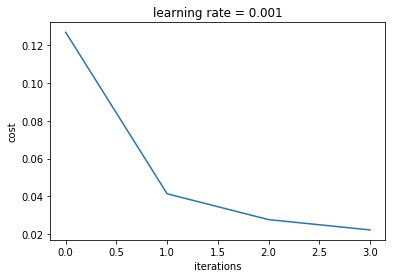

In [17]:
mnist_model = model(X_train, Y_train, X_test, Y_test)